In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from samplers import *

#### Generate data:

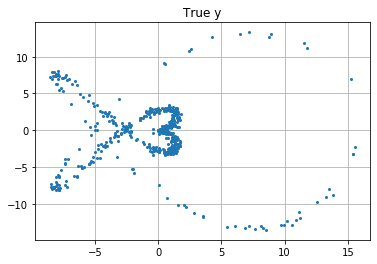

In [2]:
dd = np.load("model1.npy")
X, Y = dd.item()['X'], dd.item()['Y']
X.requires_grad = True
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y")
Nobs, n_in = np.shape(X)
n_out = np.shape(Y)[1]

### Tying down reference points:

#### Compile Stan function:

In [3]:
sm_refpoints = ps.StanModel(file="nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_230233e9492879781e4ab4965d670a58 NOW.


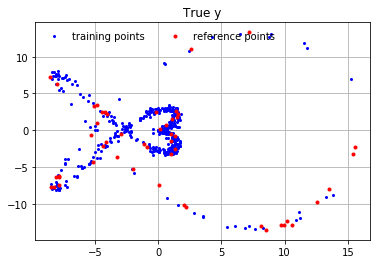

In [4]:
n_ref = 50
ref = npr.choice(int(0.25*Nobs),n_ref,replace=False) + int(0.75*Nobs)
train = np.setdiff1d(np.arange(Nobs), ref)
y_ref = Y[ref]
X_ref = X[ref].detach().numpy()
plt.plot(list(Y[train,0]), list(Y[train,1]), 'bo', markersize=2, label="training points")
plt.plot(list(Y[ref,0]), list(Y[ref,1]), 'ro', markersize=3, label="reference points")
plt.grid(True)
plt.title("True y")
plt.legend(ncol=2,frameon=False)

In [5]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=n_in, 
                      out_dim=n_out, 
                      hidden_dim_1=50,
                      n_ref=n_ref,
                      y=Y[train].detach().numpy(), 
                      y_ref=y_ref,
                      X_ref=X_ref)

#### Run sampling algorithm:

In [6]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=1,chains=1,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
125.28 minutes to run
Inference for Stan model: anon_model_230233e9492879781e4ab4965d670a58.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]           -1.14    0.09   0.58  -1.76  -1.51   -1.3  -1.03   0.41     40   1.05
X[2,1]           -0.45    0.02   0.46  -1.51  -0.73  -0.43  -0.12   0.34    526    1.0
X[3,1]           -0.39    0.02    0.5  -1.35  -0.77  -0.36   0.02   0.42    562    1.0
X[4,1]            -1.0    0.14   0.67  -1.71  -1.46  -1.24  -0.83   0.46     24    1.0
X[5,1]            0.66  2.2e-3   0.04   0.59   0.63   0.66   0.68   0.74    298    1.0
X[6,1]           -0.39    0.02    0.4  -1.11  -0.68  -0.41   -0.1   0.35    340    1.0
X[7,1]           -0.67    0.17   0.75  -1.69  

In [7]:
trace = fit_refpoints.extract()
(fit_refpoints.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([6.00000000e-01, 0.00000000e+00, 0.00000000e+00, 3.88888889e-01,
                      1.00000000e+00, 9.99610488e-01, 9.94800344e-01, 9.96732267e-01,
                      9.65171409e-01, 9.97054897e-01, 8.65843769e-01, 9.97273480e-01,
                      9.14550681e-01, 8.73891012e-01, 9.17353340e-01, 9.66210841e-01,
                      9.13196330e-01, 6.16059759e-01, 9.94589118e-01, 8.08254538e-01,
                      9.94934814e-01, 9.26587495e-01, 7.35316492e-01, 9.50337826e-01,
                      9.63225815e-01, 9.92607116e-01, 7.17971328e-01, 9.50363346e-01,
                      9.86821233e-01, 5.86240477e-01, 9.95583704e-01, 8.58123428e-01,
                      7.20114466e-01, 9.78413869e-01, 7.58771042e-01, 9.64709918e-01,
                      8.51467162e-01, 9.41906327e-01, 9.24510405e-01, 7.62603103e-01,
                      9.28383198e-01, 7.29469220e-01, 9.94324451e-01, 9.50383084e-01,
                      

### Plot IACTs:

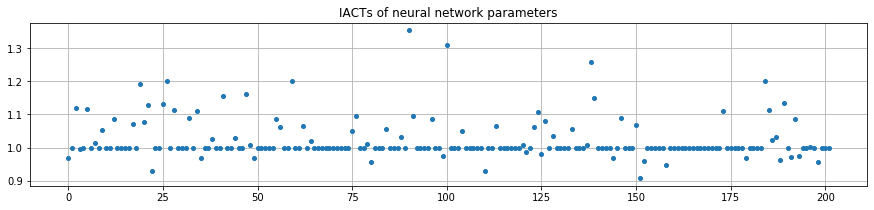

In [8]:
iact_nn = [gewer_estimate_IAT(trace['weights_1'][:,0,j]) 
          for j in range(np.shape(trace['weights_1'])[-1])] + \
         [gewer_estimate_IAT(trace['bias_1'][:,j]) 
         for j in range(np.shape(trace['bias_1'])[-1])] + \
[gewer_estimate_IAT(trace['weights_2'][:,i,j]) 
         for i in range(np.shape(trace['weights_2'])[-2]) 
         for j in range(np.shape(trace['weights_2'])[-1])] + \
[gewer_estimate_IAT(trace['bias_2'][:,j]) 
         for j in range(np.shape(trace['bias_2'])[-1])]
plt.figure(figsize=(15,3))
plt.plot(iact_nn, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of neural network parameters");

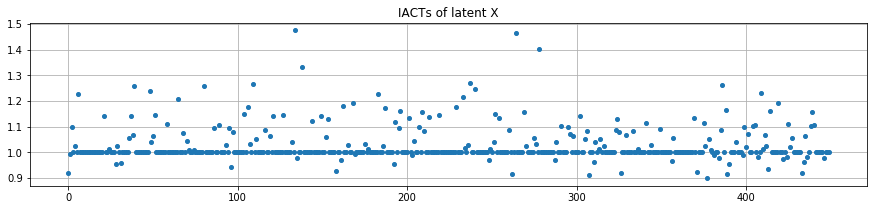

In [9]:
iact_x = [gewer_estimate_IAT(trace['X'][:,i,0]) for i in range(np.shape(trace['X'])[-2])]
plt.figure(figsize=(15,3))
plt.plot(iact_x, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of latent X");

#### Plot final:

In [19]:
n_HMC = np.shape(trace['X'])[0]
y_predicted = np.zeros((n_HMC, Nobs-50, n_out))
for i in range(Nobs-50) :
    y_predicted[i] = np.matmul(np.tanh(trace['X'][i]*trace['weights_1'][i] +
                                       trace['bias_1'][i]),trace['weights_2'][i]) + \
    trace['bias_2'][i] 

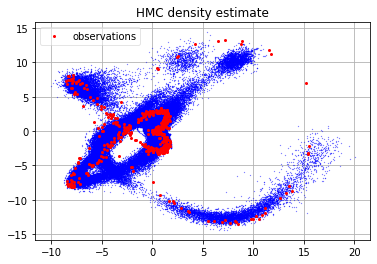

In [23]:
fig = plt.figure()
for i in range(Nobs) :
    plt.plot(y_predicted[i,:,0],y_predicted[i,:,1], 'bo', markersize=0.2)
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.grid(True)
plt.title("HMC density estimate");
plt.legend(ncol=2, loc='upper left', fancybox=True, framealpha=0.5)
fig.savefig('density_refpoints.png', dpi=1000, bbox_inches = 'tight')

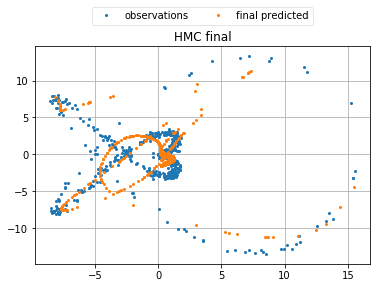

In [14]:
fig = plt.figure()
y_pred = np.matmul(np.tanh(trace['X'][-1]*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
    
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2, label="observations")
plt.plot(y_pred[:,0],y_pred[:,1], 'o', markersize=2, label="final predicted")
plt.grid(True)
plt.legend(ncol=2, loc=[0.17,1.1], fancybox=True, framealpha=0.5)
plt.title("HMC final");
fig.savefig('final_refpoints.png', dpi=1000, bbox_inches = 'tight')

### Predictive distribution:

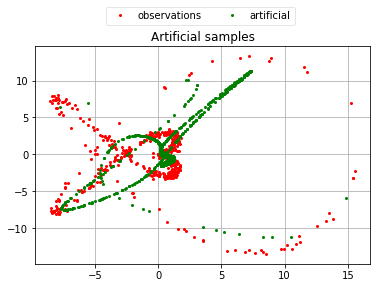

In [24]:
fig = plt.figure()
Ntest = 1_000
X_test = npr.randn(Ntest, n_in)
y_test = np.matmul(np.tanh(X_test*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_test[:,0],y_test[:,1], 'go', markersize=2, label="artificial")
plt.grid(True)
plt.title("Artificial samples");
plt.grid(True)
plt.legend(ncol=2, loc=[0.21,1.1], fancybox=True, framealpha=0.5);
fig.savefig('predicted_refpoints.png', dpi=1000, bbox_inches = 'tight')